### Zero-shot cell type annotation
Given the gene expression profiles of the cells, as well as textual descriptions of alternative cell types, LangCell can automatically perform cell type annotation.

In [1]:
import os
import sys
parent = os.path.dirname(os.path.abspath(''))
sys.path.append(parent)
os.chdir(parent)
from open_biomed.core.pipeline import InferencePipeline
from open_biomed.data import Cell, Text
from datasets import load_from_disk
import json
from open_biomed.data import Cell, Text
from sklearn.metrics import classification_report

/home/scbjtfy/anaconda3/envs/Axolotl/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Load the model
cfg_path = "./configs/model/langcell.yaml"
pipeline = InferencePipeline(model='langcell', task='cell_annotation', device='cuda:0')

Some weights of BertModel were not initialized from the model checkpoint at /data/Mamba/Project/Single_Cell/Benchmark/LangCell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# ============================================================================
# Configuration: Modify these variables to change dataset and output paths
# ============================================================================
DATASET_NAME = 'D099'  # Options: 'A013', 'D099_1k', 'PBMC10K', etc.
DATA_BASE_DIR = '/data/Mamba/Project/Single_Cell/Benchmark/LangCell'
OUTPUT_BASE_DIR = '/home/scbjtfy/OpenBioMed/eval/cell_type'

# Construct paths
data_dir = f'{DATA_BASE_DIR}/data_{DATASET_NAME}'
output_dir = f'{OUTPUT_BASE_DIR}/{DATASET_NAME}'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Dataset: {DATASET_NAME}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print("=" * 80)

# ============================================================================
# Load the dataset
# ============================================================================
dataset = load_from_disk(f'{data_dir}/dataset')
type2text = json.load(open(f'{data_dir}/type2text.json'))

print(f"\nLoaded {len(dataset)} cells with {len(type2text)} cell types")
print("\nCell type descriptions:")
print("=" * 80)
for type in type2text:
    print(f"{type} ---- {type2text[type][:100]}...\n")

# ============================================================================
# Cell Type Mapping Dictionaries for Label Standardization
# ============================================================================

# A013 Dataset: Immune cells - standardize cell type names
CELLTYPE_MAPPING_A013 = {
    "alpha-beta memory T cell": "Alpha-beta memory T cell",
    "alpha-beta T cell": "Alpha-beta T cell",
    "CD14-low": "CD14-low monocyte",
    "CD14-positive monocyte": "CD14+ monocyte",
    "CD16-negative": "CD16-negative monocyte",
    "CD16-negative classical monocyte": "CD16-negative classical monocyte",
    "CD56-dim natural killer cell": "CD56^dim NK cell",
    "central memory CD4-positive, alpha-beta T cell": "Central memory CD4+ T cell",
    "conventional dendritic cell": "Conventional dendritic cell",
    "effector memory CD4-positive, alpha-beta T cell": "Effector memory CD4+ T cell",
    "effector memory CD8-positive, alpha-beta T cell": "Effector memory CD8+ T cell",
    "gamma-delta T cell": "Gamma-delta T cell",
    "memory B cell": "Memory B cell",
    "mucosal invariant T cell": "MAIT cell",
    "naive B cell": "Naive B cell",
    "naive thymus-derived CD4-positive, alpha-beta T cell": "Naive CD4+ T cell",
    "naive thymus-derived CD8-positive, alpha-beta T cell": "Naive CD8+ T cell",
    "natural killer cell": "NK cell",
    "plasmablast": "Plasmablast",
    "plasmacytoid dendritic cell": "Plasmacytoid dendritic cell",
    "transitional stage B cell": "Transitional B cell",
    "CD14-low, CD16-positive monocyte": "CD14-low CD16+ monocyte",
    "CD16-negative, CD56-bright natural killer cell, human": "CD56^bright NK cell",
    "central memory CD8-positive, alpha-beta T cell": "Central memory CD8+ T cell",
    "double negative thymocyte": "Double negative thymocyte",
    "regulatory T cell": "Regulatory T cell",
    "CD4-positive, alpha-beta cytotoxic T cell": "CD4+ cytotoxic T cell",
}

# D099 Dataset: Map detailed cell types to state labels
# True labels use states (Basal, Ciliated, etc.)
# Predicted labels may use detailed cell types - need to map to states
CELLTYPE_TO_STATE_D099 = {
    # Basal cells (all variants map to "Basal")
    "basal cell": "Basal",
    "basal cell of epidermis": "Basal",
    "basal cell of epithelium of bronchus": "Basal",
    "basal cell of epithelium of trachea": "Basal",
    "basal cell of prostate epithelium": "Basal",
    "respiratory basal cell": "Basal",
    "Basal": "Basal",
    "Differentiating.Basal": "Differentiating Basal",
    "Proliferating.Basal": "Proliferating Basal",
    "Transitioning.Basal": "Transitioning Basal",
    "Suprabasal": "Suprabasal",
    
    # Ciliated cells (all variants map to "Ciliated")
    "ciliated cell": "Ciliated",
    "ciliated cell of the bronchus": "Ciliated",
    "lung ciliated cell": "Ciliated",
    "Ciliated": "Ciliated",
    
    # Secretory cells (goblet cells are secretory)
    "secretory cell": "Secretory",
    "lung secretory cell": "Secretory",
    "goblet cell": "Secretory",
    "lung goblet cell": "Secretory",
    "nasal mucosa goblet cell": "Secretory",
    "tracheal goblet cell": "Secretory",
    "Secretory": "Secretory",
    
    # Club cells (also secretory in function)
    "club cell": "Secretory",
    
    # Brush cells (rare epithelial cell type)
    "brush cell": "Secretory",
    
    # Type II pneumocytes (secretory function)
    "type II pneumocyte": "Secretory",
}

# Determine which mapping to use based on dataset name
if 'A013' in DATASET_NAME:
    ACTIVE_MAPPING = CELLTYPE_MAPPING_A013
    MAPPING_TYPE = 'celltype_standardization'
elif 'D099' in DATASET_NAME:
    ACTIVE_MAPPING = CELLTYPE_TO_STATE_D099
    MAPPING_TYPE = 'celltype_to_state'
else:
    ACTIVE_MAPPING = {}
    MAPPING_TYPE = 'none'

print("\n" + "="*80)
print("LABEL MAPPING CONFIGURATION")
print("="*80)
print(f"Dataset: {DATASET_NAME}")
print(f"Mapping type: {MAPPING_TYPE}")
print(f"Number of mappings: {len(ACTIVE_MAPPING)}")
if ACTIVE_MAPPING:
    print("\nSample mappings:")
    for i, (k, v) in enumerate(list(ACTIVE_MAPPING.items())[:5]):
        print(f"  '{k}' → '{v}'")
    if len(ACTIVE_MAPPING) > 5:
        print(f"  ... and {len(ACTIVE_MAPPING) - 5} more")
print("="*80)

Dataset: D099
Data directory: /data/Mamba/Project/Single_Cell/Benchmark/LangCell/data_D099
Output directory: /home/scbjtfy/OpenBioMed/eval/cell_type/D099

Loaded 15806 cells with 36 cell types

Cell type descriptions:
central memory CD4-positive, alpha-beta T cell ---- cell type: central memory cd4-positive, alpha-beta t cell. a memory t cell subset that expresses cd4...

naive thymus-derived CD4-positive, alpha-beta T cell ---- cell type: naive thymus-derived cd4-positive, alpha-beta t cell. a cd4-positive t cell that has emig...

effector memory CD4-positive, alpha-beta T cell ---- cell type: effector memory cd4-positive, alpha-beta t cell. a cd4-positive memory t cell with immedi...

regulatory T cell ---- cell type: regulatory t cell. a specialized cd4-positive t cell subset that maintains immune homeost...

CD4-positive, alpha-beta cytotoxic T cell ---- cell type: cd4-positive, alpha-beta cytotoxic t cell. an atypical cd4-positive t cell with cytotoxic...

naive thymus-derived CD8

In [4]:
type2text

{'central memory CD4-positive, alpha-beta T cell': 'cell type: central memory cd4-positive, alpha-beta t cell. a memory t cell subset that expresses cd4 and has undergone antigen-driven clonal expansion. characterized by ccr7-positive, cd45ra-negative, cd127-positive, and cd62l-positive phenotype. these cells reside in secondary lymphoid organs and possess high proliferative capacity upon antigen re-encounter.',
 'naive thymus-derived CD4-positive, alpha-beta T cell': 'cell type: naive thymus-derived cd4-positive, alpha-beta t cell. a cd4-positive t cell that has emigrated from the thymus but has not yet encountered its cognate antigen. characterized by ccr7-positive, cd45ra-positive, cd45ro-negative, and cd62l-high phenotype. these cells circulate through blood and lymphoid tissues seeking antigen presentation.',
 'effector memory CD4-positive, alpha-beta T cell': 'cell type: effector memory cd4-positive, alpha-beta t cell. a cd4-positive memory t cell with immediate effector function

In [5]:
dataset

Dataset({
    features: ['input_ids', 'str_labels'],
    num_rows: 15806
})

In [6]:
from collections import Counter

label_counts = Counter(dataset["str_labels"])

for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{label:20s} : {count}")

Secretory            : 6265
Basal                : 3947
Differentiating.Basal : 2065
Suprabasal           : 1272
Proliferating.Basal  : 1097
Transitioning.Basal  : 631
Ciliated             : 529


In [7]:
# import scanpy as sc
# adata = sc.read_h5ad('/data/Mamba/Project/Single_Cell/Benchmark/Cell2Setence/Data/A013_processed_sampled_w_cell2sentence.h5ad')
# print('=== Cell Type 分布情况 ===')
# print(adata.obs['cell_type'].value_counts())

In [8]:
dataset[0]['str_labels']

'Differentiating.Basal'

In [9]:
# random sample
# dataset = dataset.shuffle(seed=42).select(range(2000))

# random sample
dataset = dataset.shuffle(seed=42)

In [10]:
# Organize data into specific formats as model inputs
texts = []
type2label = {}
labels = []
for type in type2text:
    texts.append(Text.from_str(type2text[type]))
    type2label[type] = len(texts) - 1
input = {'cell': [], 'class_texts': [], 'label': []}
for data in dataset:
    input['cell'].append(Cell.from_sequence(data['input_ids']))
    input['class_texts'].append(texts)
    input['label'].append(type2label[data['str_labels']])
    labels.append(type2label[data['str_labels']])

In [11]:
# Predict the cell type of each cell using the model
preds, _ = pipeline.run(batch_size=4, **input)
preds = [p.item() for p in preds]

Inference Steps:   0%|          | 0/3952 [00:00<?, ?it/s]/home/scbjtfy/OpenBioMed/open_biomed/models/cell/langcell/langcell_utils.py:1039: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {'cell': torch.tensor(batch['input_ids'], dtype=torch.int64),
/home/scbjtfy/OpenBioMed/open_biomed/models/cell/langcell/langcell_utils.py:1040: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(batch['attention_mask'], dtype=torch.int64),
Inference Steps: 100%|█████████▉| 3951/3952 [1:11:20<00:01,  1.08s/it]


IndexError: list index out of range

In [ ]:
preds

NameError: name 'preds' is not defined

: 

In [ ]:
# ============================================================================
# Apply Label Mapping for Standardization
# ============================================================================

# Function to map labels based on active mapping configuration
def map_label(label_text, mapping_dict):
    """Map a label using the provided mapping dictionary"""
    if label_text in mapping_dict:
        return mapping_dict[label_text]
    # If no exact match, try case-insensitive matching
    for key, value in mapping_dict.items():
        if key.lower() == label_text.lower():
            return value
    # If still no match, return original (with warning)
    return label_text

# Convert numeric labels to cell type names first
cell_type_list = list(type2text.keys())
true_labels_original = [cell_type_list[label] for label in labels]
pred_labels_original = [cell_type_list[pred] for pred in preds]

# Apply mapping if configured
if ACTIVE_MAPPING:
    print("="*80)
    print(f"APPLYING LABEL MAPPING: {MAPPING_TYPE}")
    print("="*80)
    
    # Map true labels
    true_labels_mapped = [map_label(label, ACTIVE_MAPPING) for label in true_labels_original]
    
    # Map predicted labels
    pred_labels_mapped = [map_label(label, ACTIVE_MAPPING) for label in pred_labels_original]
    
    # Count mappings
    unmapped_true = [label for label in set(true_labels_original) if map_label(label, ACTIVE_MAPPING) == label and label not in ACTIVE_MAPPING]
    unmapped_pred = [label for label in set(pred_labels_original) if map_label(label, ACTIVE_MAPPING) == label and label not in ACTIVE_MAPPING]
    
    print(f"\nTrue labels:")
    print(f"  Original unique labels: {len(set(true_labels_original))}")
    print(f"  Mapped unique labels: {len(set(true_labels_mapped))}")
    if unmapped_true:
        print(f"  ⚠ Unmapped labels: {len(unmapped_true)}")
        for label in sorted(unmapped_true)[:5]:
            print(f"    - '{label}'")
        if len(unmapped_true) > 5:
            print(f"    ... and {len(unmapped_true) - 5} more")
    
    print(f"\nPredicted labels:")
    print(f"  Original unique labels: {len(set(pred_labels_original))}")
    print(f"  Mapped unique labels: {len(set(pred_labels_mapped))}")
    if unmapped_pred:
        print(f"  ⚠ Unmapped labels: {len(unmapped_pred)}")
        for label in sorted(unmapped_pred)[:5]:
            print(f"    - '{label}'")
        if len(unmapped_pred) > 5:
            print(f"    ... and {len(unmapped_pred) - 5} more")
    
    # Show mapping examples
    print(f"\nMapping examples (first 10):")
    for i in range(min(10, len(true_labels_original))):
        true_orig = true_labels_original[i]
        true_map = true_labels_mapped[i]
        pred_orig = pred_labels_original[i]
        pred_map = pred_labels_mapped[i]
        
        true_changed = " ✓" if true_orig != true_map else ""
        pred_changed = " ✓" if pred_orig != pred_map else ""
        
        print(f"  [{i}] True: '{true_orig}' → '{true_map}'{true_changed}")
        print(f"      Pred: '{pred_orig}' → '{pred_map}'{pred_changed}")
    
    # Update labels for evaluation
    true_labels_for_eval = true_labels_mapped
    pred_labels_for_eval = pred_labels_mapped
    
    # Calculate accuracy with mapped labels
    correct_mapped = sum(1 for t, p in zip(true_labels_mapped, pred_labels_mapped) if t == p)
    accuracy_mapped = correct_mapped / len(true_labels_mapped)
    
    print(f"\n" + "="*80)
    print(f"MAPPING RESULT")
    print("="*80)
    print(f"Total samples: {len(true_labels_mapped)}")
    print(f"Correct predictions (after mapping): {correct_mapped}")
    print(f"Accuracy (after mapping): {accuracy_mapped:.4f} ({accuracy_mapped*100:.2f}%)")
    print("="*80)
    
else:
    print("="*80)
    print("NO LABEL MAPPING CONFIGURED")
    print("="*80)
    print("Using original labels for evaluation")
    print("="*80)
    
    true_labels_for_eval = true_labels_original
    pred_labels_for_eval = pred_labels_original

# Store for later use
labels_str = true_labels_for_eval  # For string-based analysis
preds_str = pred_labels_for_eval   # For string-based analysis


APPLYING LABEL MAPPING: celltype_standardization

True labels:
  Original unique labels: 22
  Mapped unique labels: 22
  ⚠ Unmapped labels: 1
    - 'hematopoietic precursor cell'

Predicted labels:
  Original unique labels: 14
  Mapped unique labels: 14

Mapping examples (first 10):
  [0] True: 'CD14-positive monocyte' → 'CD14+ monocyte' ✓
      Pred: 'plasmacytoid dendritic cell' → 'Plasmacytoid dendritic cell' ✓
  [1] True: 'CD14-positive monocyte' → 'CD14+ monocyte' ✓
      Pred: 'CD14-positive monocyte' → 'CD14+ monocyte' ✓
  [2] True: 'CD14-positive monocyte' → 'CD14+ monocyte' ✓
      Pred: 'CD14-low, CD16-positive monocyte' → 'CD14-low CD16+ monocyte' ✓
  [3] True: 'conventional dendritic cell' → 'Conventional dendritic cell' ✓
      Pred: 'CD14-positive monocyte' → 'CD14+ monocyte' ✓
  [4] True: 'central memory CD4-positive, alpha-beta T cell' → 'Central memory CD4+ T cell' ✓
      Pred: 'plasmablast' → 'Plasmablast' ✓
  [5] True: 'effector memory CD8-positive, alpha-beta T cel


EVALUATION METRICS - A013
Accuracy:           0.0460 (4.60%)

Macro Metrics:
  Precision:        0.0556
  Recall:           0.1148
  F1-Score:         0.0152

Weighted Metrics:
  Precision:        0.3374
  Recall:           0.0460
  F1-Score:         0.0275



✓ Saved count confusion matrix: /home/scbjtfy/OpenBioMed/eval/cell_type/A013/confusion_matrix_count.png


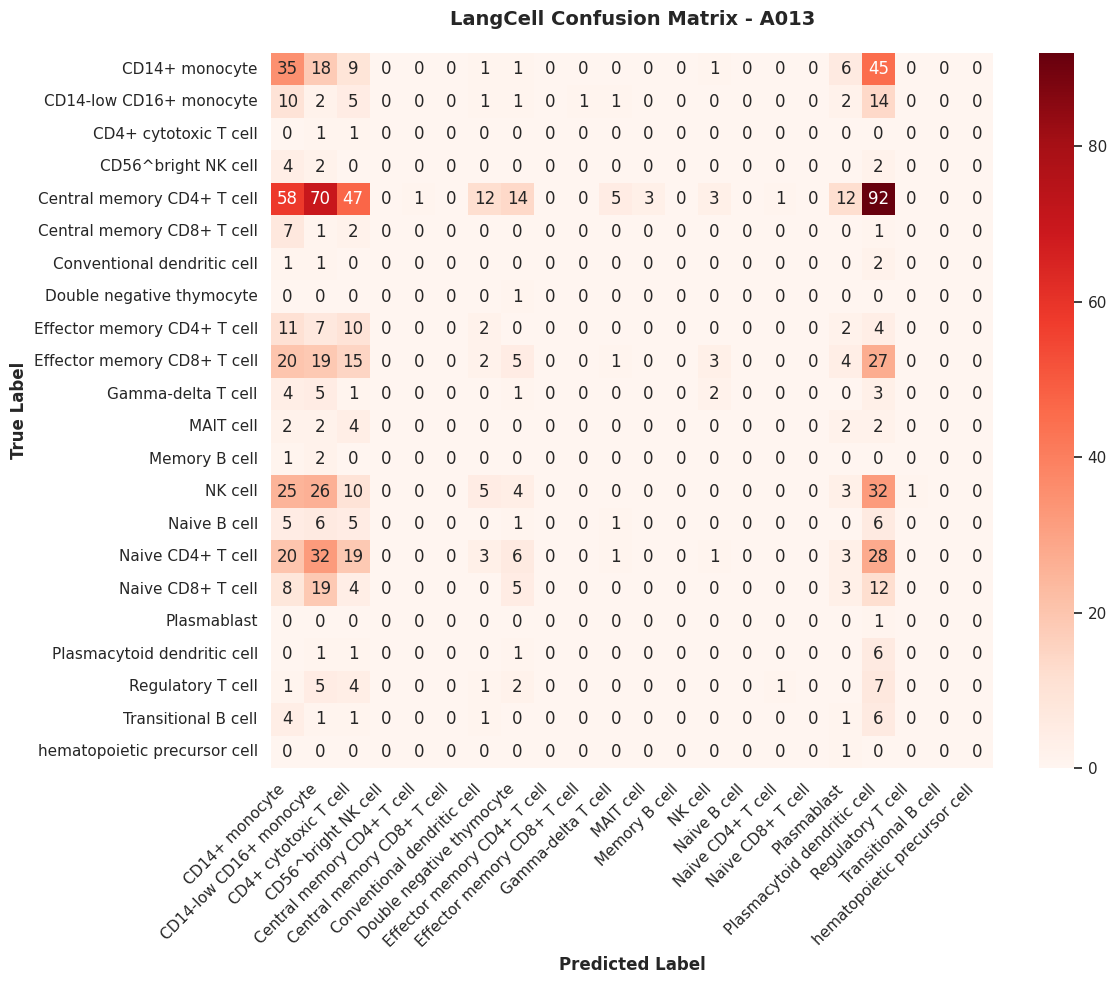


PER CELL TYPE METRICS
Cell Type                            Total  Correct    Acc   Prec Recall     F1
--------------------------------------------------------------------------------
CD14+ monocyte                         116       35  0.302  0.162  0.302  0.211
CD14-low CD16+ monocyte                 37        2  0.054  0.009  0.054  0.016
CD4+ cytotoxic T cell                    2        1  0.500  0.007  0.500  0.014
CD56^bright NK cell                      8        0  0.000  0.000  0.000  0.000
Central memory CD4+ T cell             318        1  0.003  1.000  0.003  0.006
Central memory CD8+ T cell              11        0  0.000  0.000  0.000  0.000
Conventional dendritic cell              4        0  0.000  0.000  0.000  0.000
Double negative thymocyte                1        1  1.000  0.024  1.000  0.047
Effector memory CD4+ T cell             36        0  0.000  0.000  0.000  0.000
Effector memory CD8+ T cell             96        0  0.000  0.000  0.000  0.000
Gamma-delta T ce

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np

# Use mapped labels for evaluation (from previous cell)
# labels_str and preds_str contain the standardized cell type names

# Get unique cell types that actually exist in the dataset (after mapping)
unique_cell_types = sorted(set(labels_str))

# Calculate confusion matrix using mapped labels
cm = confusion_matrix(labels_str, preds_str, labels=unique_cell_types)

# ============================================================================
# Calculate evaluation metrics
# ============================================================================
# Overall accuracy
accuracy = accuracy_score(labels_str, preds_str)

# Macro and weighted metrics
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    labels_str, preds_str, average='macro', labels=unique_cell_types, zero_division=0
)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    labels_str, preds_str, average='weighted', labels=unique_cell_types, zero_division=0
)

# Per-class metrics
per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
    labels_str, preds_str, labels=unique_cell_types, zero_division=0
)

# Print metrics summary
print("\n" + "="*80)
print(f"EVALUATION METRICS - {DATASET_NAME}")
print("="*80)
print(f"Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nMacro Metrics:")
print(f"  Precision:        {macro_precision:.4f}")
print(f"  Recall:           {macro_recall:.4f}")
print(f"  F1-Score:         {macro_f1:.4f}")
print(f"\nWeighted Metrics:")
print(f"  Precision:        {weighted_precision:.4f}")
print(f"  Recall:           {weighted_recall:.4f}")
print(f"  F1-Score:         {weighted_f1:.4f}")
print("="*80)

# ============================================================================
# Plot confusion matrix (Count)
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=unique_cell_types,
            yticklabels=unique_cell_types,
            ax=ax,
        )

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title(f'LangCell Confusion Matrix - {DATASET_NAME}', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure BEFORE plt.show()
count_fig_path = f'{output_dir}/confusion_matrix_count.png'
plt.savefig(count_fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved count confusion matrix: {count_fig_path}")

plt.show()
plt.close()

# ============================================================================
# Print per-class metrics
# ============================================================================
print("\n" + "="*80)
print("PER CELL TYPE METRICS")
print("="*80)
print(f"{'Cell Type':<35} {'Total':>6} {'Correct':>8} {'Acc':>6} {'Prec':>6} {'Recall':>6} {'F1':>6}")
print("-"*80)
for i, cell_type in enumerate(unique_cell_types):
    total = per_class_support[i]
    correct = cm[i, i]
    acc = correct / total if total > 0 else 0
    prec = per_class_precision[i]
    rec = per_class_recall[i]
    f1 = per_class_f1[i]
    print(f"{cell_type:<35} {total:>6} {correct:>8} {acc:>6.3f} {prec:>6.3f} {rec:>6.3f} {f1:>6.3f}")
print("="*80)



In [ ]:
# ============================================================================
# Save evaluation results to files
# ============================================================================
import json

# Save confusion matrix data
cm_data = {
    'dataset': DATASET_NAME,
    'confusion_matrix': cm.tolist(),
    'cell_types': unique_cell_types,
    'metrics': {
        'accuracy': float(accuracy),
        'macro_precision': float(macro_precision),
        'macro_recall': float(macro_recall),
        'macro_f1': float(macro_f1),
        'weighted_precision': float(weighted_precision),
        'weighted_recall': float(weighted_recall),
        'weighted_f1': float(weighted_f1)
    },
    'per_class_metrics': {
        cell_type: {
            'total': int(per_class_support[i]),
            'correct': int(cm[i, i]),
            'accuracy': float(cm[i, i] / per_class_support[i] if per_class_support[i] > 0 else 0),
            'precision': float(per_class_precision[i]),
            'recall': float(per_class_recall[i]),
            'f1': float(per_class_f1[i])
        }
        for i, cell_type in enumerate(unique_cell_types)
    }
}

cm_json_path = f'{output_dir}/evaluation_results.json'
with open(cm_json_path, 'w') as f:
    json.dump(cm_data, f, indent=2)
print(f"✓ Saved evaluation results: {cm_json_path}")

# Save metrics summary as text file
metrics_txt_path = f'{output_dir}/metrics_summary.txt'
with open(metrics_txt_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write(f"EVALUATION METRICS - {DATASET_NAME}\n")
    f.write("="*80 + "\n")
    f.write(f"Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"\nMacro Metrics:\n")
    f.write(f"  Precision:        {macro_precision:.4f}\n")
    f.write(f"  Recall:           {macro_recall:.4f}\n")
    f.write(f"  F1-Score:         {macro_f1:.4f}\n")
    f.write(f"\nWeighted Metrics:\n")
    f.write(f"  Precision:        {weighted_precision:.4f}\n")
    f.write(f"  Recall:           {weighted_recall:.4f}\n")
    f.write(f"  F1-Score:         {weighted_f1:.4f}\n")
    f.write("="*80 + "\n\n")
    
    f.write("="*80 + "\n")
    f.write("PER CELL TYPE METRICS\n")
    f.write("="*80 + "\n")
    f.write(f"{'Cell Type':<35} {'Total':>6} {'Correct':>8} {'Acc':>6} {'Prec':>6} {'Recall':>6} {'F1':>6}\n")
    f.write("-"*80 + "\n")
    for i, cell_type in enumerate(unique_cell_types):
        total = per_class_support[i]
        correct = cm[i, i]
        acc = correct / total if total > 0 else 0
        prec = per_class_precision[i]
        rec = per_class_recall[i]
        f1 = per_class_f1[i]
        f.write(f"{cell_type:<35} {total:>6} {correct:>8} {acc:>6.3f} {prec:>6.3f} {rec:>6.3f} {f1:>6.3f}\n")
    f.write("="*80 + "\n")
    
print(f"✓ Saved metrics summary: {metrics_txt_path}")

# Save sklearn classification report
from sklearn.metrics import classification_report

report_txt_path = f'{output_dir}/classification_report.txt'
with open(report_txt_path, 'w') as f:
    report = classification_report(labels_str, preds_str, 
                                   labels=unique_cell_types,
                                   target_names=unique_cell_types,
                                   zero_division=0)
    f.write(report)
print(f"✓ Saved classification report: {report_txt_path}")

print("\n" + "="*80)
print(f"✓ All evaluation results saved to: {output_dir}")
print("="*80)
print("\nGenerated evaluation files:")
print(f"  - {output_dir}/confusion_matrix_count.png")
print(f"  - {output_dir}/evaluation_results.json")
print(f"  - {output_dir}/metrics_summary.txt")
print(f"  - {output_dir}/classification_report.txt")


✓ Saved evaluation results: /home/scbjtfy/OpenBioMed/eval/cell_type/A013/evaluation_results.json
✓ Saved metrics summary: /home/scbjtfy/OpenBioMed/eval/cell_type/A013/metrics_summary.txt
✓ Saved classification report: /home/scbjtfy/OpenBioMed/eval/cell_type/A013/classification_report.txt

✓ All evaluation results saved to: /home/scbjtfy/OpenBioMed/eval/cell_type/A013

Generated evaluation files:
  - /home/scbjtfy/OpenBioMed/eval/cell_type/A013/confusion_matrix_count.png
  - /home/scbjtfy/OpenBioMed/eval/cell_type/A013/evaluation_results.json
  - /home/scbjtfy/OpenBioMed/eval/cell_type/A013/metrics_summary.txt
  - /home/scbjtfy/OpenBioMed/eval/cell_type/A013/classification_report.txt


In [ ]:
# ============================================================================
# Save predictions with cell type names (not numeric labels)
# ============================================================================
import pandas as pd

# Use the mapped labels from Cell 12 (labels_str and preds_str)
# These contain standardized cell type names after mapping

# Create DataFrame with predictions (using mapped/standardized labels)
predictions_df = pd.DataFrame({
    'index': range(len(labels_str)),
    'true_label': labels_str,
    'predicted_label': preds_str,
    'correct': [true == pred for true, pred in zip(labels_str, preds_str)]
})

# Also save original (unmapped) labels for reference if mapping was applied
if ACTIVE_MAPPING:
    predictions_df.insert(2, 'true_label_original', true_labels_original)
    predictions_df.insert(4, 'predicted_label_original', pred_labels_original)

# Save to CSV
predictions_csv_path = f'{output_dir}/predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"\n✓ Saved predictions (CSV): {predictions_csv_path}")

# Save to JSON (more detailed format)
predictions_json = []
for i in range(len(predictions_df)):
    record = {
        'index': int(predictions_df.loc[i, 'index']),
        'true_label': predictions_df.loc[i, 'true_label'],
        'predicted_label': predictions_df.loc[i, 'predicted_label'],
        'correct': bool(predictions_df.loc[i, 'correct'])
    }
    # Add original labels if mapping was applied
    if ACTIVE_MAPPING:
        record['true_label_original'] = predictions_df.loc[i, 'true_label_original']
        record['predicted_label_original'] = predictions_df.loc[i, 'predicted_label_original']
    predictions_json.append(record)

predictions_json_path = f'{output_dir}/predictions_detailed.json'
with open(predictions_json_path, 'w') as f:
    json.dump(predictions_json, f, indent=2)
print(f"✓ Saved predictions (JSON): {predictions_json_path}")

# Save to plain text (human-readable)
predictions_txt_path = f'{output_dir}/predictions.txt'
with open(predictions_txt_path, 'w') as f:
    f.write("="*100 + "\n")
    f.write(f"CELL TYPE PREDICTIONS - {DATASET_NAME}\n")
    f.write("="*100 + "\n")
    f.write(f"{'Index':<8} {'True Label':<40} {'Predicted Label':<40} {'Correct':<8}\n")
    f.write("-"*100 + "\n")
    
    for i in range(len(predictions_df)):
        true_label = predictions_df.loc[i, 'true_label']
        pred_label = predictions_df.loc[i, 'predicted_label']
        correct = predictions_df.loc[i, 'correct']
        status = "✓" if correct else "✗"
        f.write(f"{i:<8} {true_label:<40} {pred_label:<40} {status:<8}\n")
    
    f.write("="*100 + "\n")
    f.write(f"\nTotal samples: {len(predictions_df)}\n")
    f.write(f"Correct predictions: {predictions_df['correct'].sum()}\n")
    f.write(f"Incorrect predictions: {(~predictions_df['correct']).sum()}\n")
    f.write(f"Accuracy: {predictions_df['correct'].mean():.4f} ({predictions_df['correct'].mean()*100:.2f}%)\n")

print(f"✓ Saved predictions (TXT): {predictions_txt_path}")

# Print summary
print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(f"Total samples:           {len(predictions_df)}")
print(f"Correct predictions:     {predictions_df['correct'].sum()} ({predictions_df['correct'].mean()*100:.2f}%)")
print(f"Incorrect predictions:   {(~predictions_df['correct']).sum()} ({(~predictions_df['correct']).mean()*100:.2f}%)")
print("="*80)

# Show first 10 predictions
print("\nFirst 10 predictions:")
print("-"*80)
print(predictions_df.head(10).to_string(index=False))

# Show misclassified examples (first 5)
misclassified = predictions_df[~predictions_df['correct']]
if len(misclassified) > 0:
    print(f"\n\nFirst 5 misclassified examples (out of {len(misclassified)} total):")
    print("-"*80)
    print(misclassified.head(5).to_string(index=False))
else:
    print("\n\n🎉 No misclassifications! Perfect accuracy!")

print("\n" + "="*80)
print(f"✓ All prediction files saved to: {output_dir}")
print("="*80)



✓ Saved predictions (CSV): /home/scbjtfy/OpenBioMed/eval/cell_type/A013/predictions.csv
✓ Saved predictions (JSON): /home/scbjtfy/OpenBioMed/eval/cell_type/A013/predictions_detailed.json
✓ Saved predictions (TXT): /home/scbjtfy/OpenBioMed/eval/cell_type/A013/predictions.txt

PREDICTION SUMMARY
Total samples:           1000
Correct predictions:     46 (4.60%)
Incorrect predictions:   954 (95.40%)

First 10 predictions:
--------------------------------------------------------------------------------
 index                  true_label                             true_label_original             predicted_label         predicted_label_original  correct
     0              CD14+ monocyte                          CD14-positive monocyte Plasmacytoid dendritic cell      plasmacytoid dendritic cell    False
     1              CD14+ monocyte                          CD14-positive monocyte              CD14+ monocyte           CD14-positive monocyte     True
     2              CD14+ monocyte   